# UTC - EDA

Greg Welliver   

In [1]:
# Import relevant libraries and packages.
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 
import warnings
from scipy import stats
import re
from glob import glob, iglob
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime, timedelta


# Seaborn settings
sns.set_context('notebook')
#sns.set_style("whitegrid")
#sns.set_style("white")
style_set = sns.set_style('whitegrid')
pd.options.display.float_format = '{:,}'.format
color_choice1 = 'plum'
color_choice2 = 'lightblue'
color_choice3 = 'lightgreen'
#ax.yaxis.set_major_formatter('{x:,.0f}')
#sns.set_context('notebook', font_scale = 4)

%matplotlib inline
import pandas as pd
#from mpl_toolkits.basemap import Basemap

import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as ctx

from sklearn.feature_extraction.text import CountVectorizer

import json
from ydata_profiling import ProfileReport
import calendar


# Part 1 - EDA

## Load the data



In [2]:
# load data
df1 = pd.read_json('logins.json')
dfx1 = pd.read_json('ultimate_data_challenge.json')

In [3]:
df1.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


profile = ProfileReport(df1)
profile

## <font color='orange'>Data Quality Observations</font>
- according to the profiling report, there are 868 duplicate rows (0.9%) - there is no need to remove these, as it is possible that two users logged in at the same time
- there are not any nulls

In [4]:
days = list(calendar.day_abbr)
months = list(calendar.month_abbr)

In [5]:
df2 = df1

In [6]:
df2['count'] = 1

In [7]:
df2 = df2.set_index('login_time')

In [8]:
# group the logins by 15 minute intervals
df2g = df2.groupby(pd.Grouper(freq='15Min')).aggregate(np.sum) 
df2g['count'] = df2g['count'].fillna(0)
df2g.head(10)

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


## <font color='orange'>View the entire time series</font>

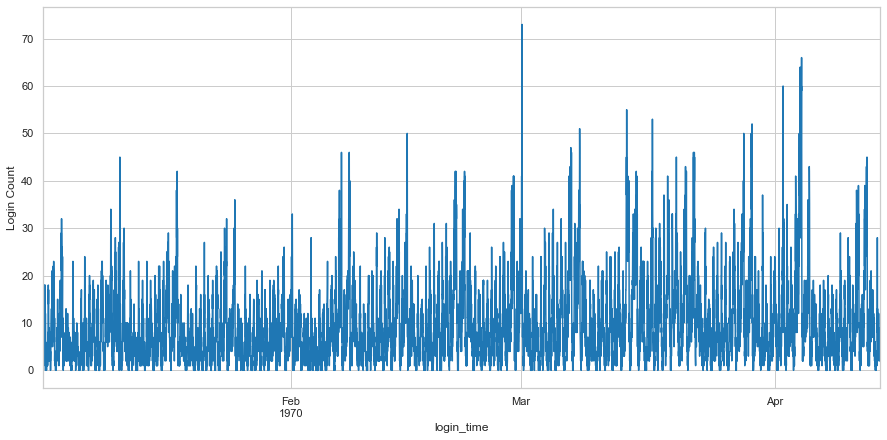

In [9]:
fig, ax = plt.subplots(figsize = (15 , 7))
ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
df2g['count'].plot();

#### Observations:
- It does appear that the data follows some sort of cyclical pattern.  We'll need to look more closely at shorter time intervals to get a better sense of the patterns

In [10]:
df2g = df2g.reset_index()

In [11]:
df2g.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [12]:
df2g['timestamp'] = pd.to_datetime(df2g.login_time)

In [13]:
df2g['month'] = df2g['timestamp'].apply(lambda x: months[x.month])
df2g['day'] = df2g['timestamp'].apply(lambda x: days[x.weekday()])
df2g['hour'] = df2g['timestamp'].apply(lambda x: x.hour)
df2g['time'] = df2g['timestamp'].apply(lambda x: x.time())

In [14]:
df2g.head()

,login_time,count,timestamp,month,day,hour,time
0,1970-01-01 20:00:00,2,1970-01-01 20:00:00,Jan,Thu,20,20:00:00
1,1970-01-01 20:15:00,6,1970-01-01 20:15:00,Jan,Thu,20,20:15:00
2,1970-01-01 20:30:00,9,1970-01-01 20:30:00,Jan,Thu,20,20:30:00
3,1970-01-01 20:45:00,7,1970-01-01 20:45:00,Jan,Thu,20,20:45:00
4,1970-01-01 21:00:00,1,1970-01-01 21:00:00,Jan,Thu,21,21:00:00


## <font color='orange'>Let's look at logins over the course of a day, by aggregating all of the days</font>

''

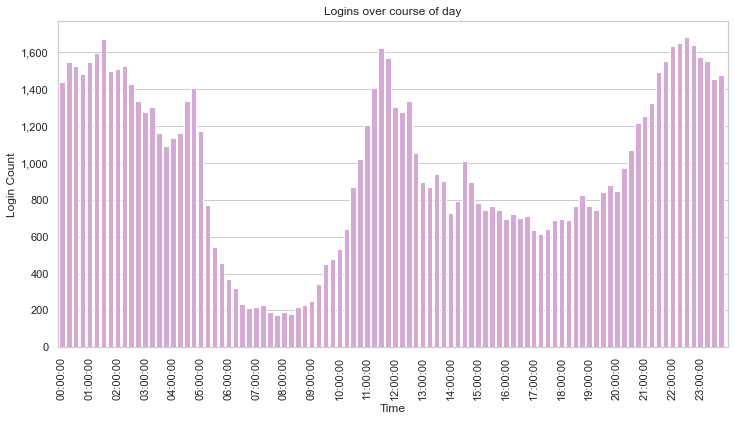

In [15]:
df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Logins over course of day")
sns.barplot(x = 'time', y = 'count', data = df_day,
            color = color_choice1
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_day)+1, 4))
plt.xticks(rotation=90)
;

''

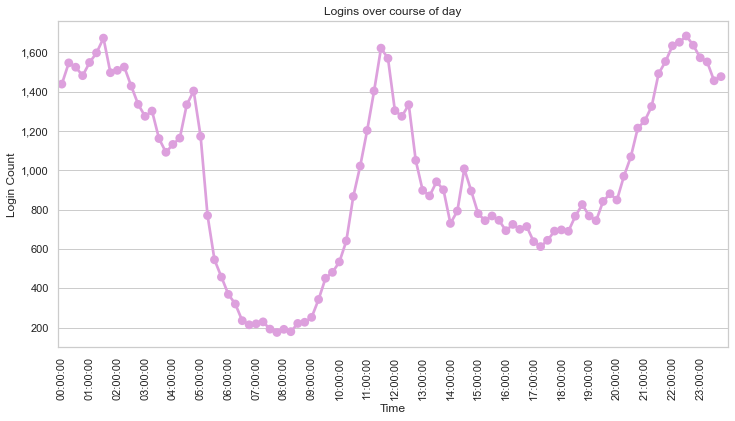

In [16]:
df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))
plt.title("Logins over course of day")
sns.pointplot(x = 'time', y = 'count', data = df_day,
            color = color_choice1
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Time" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(df_day)+1, 4))
plt.xticks(rotation=90)
;

#### Observations:
- Logins appear to peak later in the evening and early in the morning, with another peak around midday.  Usage bottoms at around 8AM, and the afternoon displays a meangingful dip from peak hours as well.

## <font color='orange'>Let's look at logins per day of week</font>

''

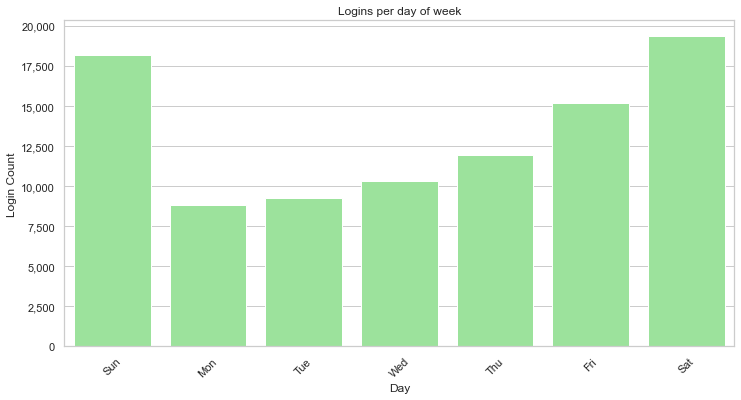

In [17]:
day_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
df_month = pd.DataFrame(df2g.groupby('day')['count'].sum().reset_index())
fig, ax = plt.subplots(figsize = (12 , 6))

plt.title("Logins per day of week")
sns.barplot(x = 'day', y = 'count', data = df_month,
            color = color_choice3, order=day_order
            )

ax.set_ylabel("Login Count" , size = 12 )
ax.set_xlabel( "Day" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(np.arange(0, len(df_month)+1, 4))
plt.xticks(rotation=45)
;

#### Observations:
- Usage peaks on Saturday and Sunday, with high volume on Thursday and Friday as well.  Usage is lowest on Monday and Tuesday (earlier in the week).  This is reminiscent of a food delivery service like DoorDash.

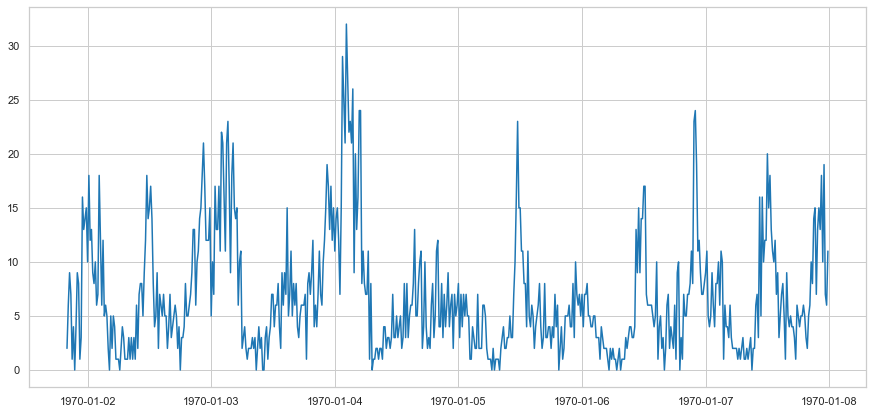

In [18]:
one_week = df2g[df2g['login_time'] < "1970-01-08"]
y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

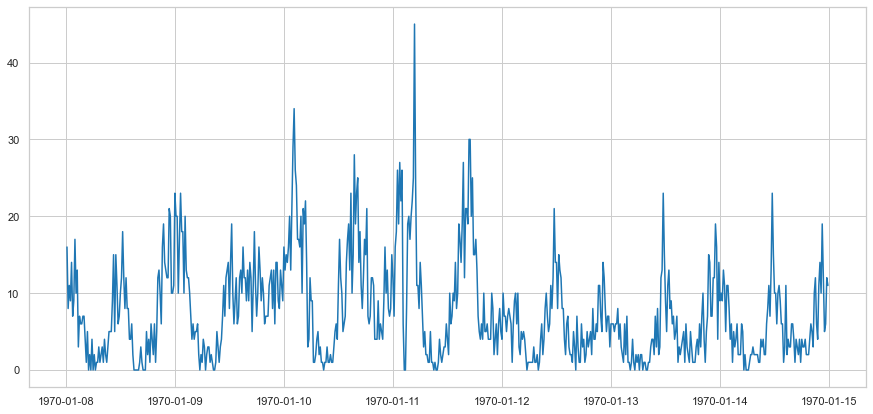

In [19]:
one_week = df2g[(df2g['login_time'] > "1970-01-08") & (df2g['login_time'] < "1970-01-15")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

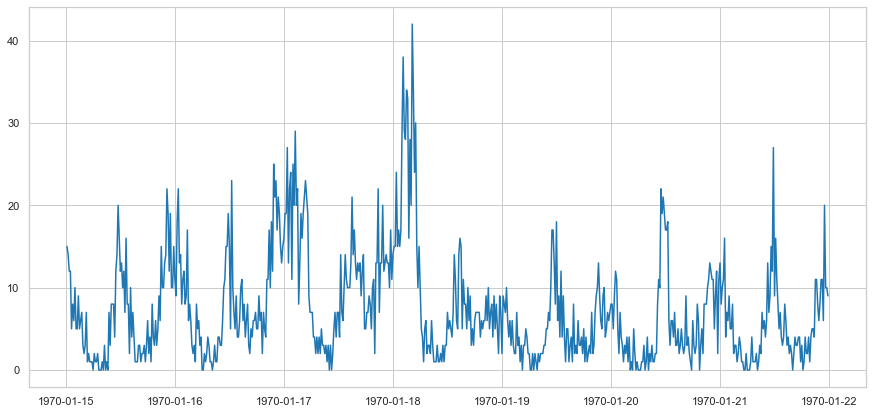

In [20]:
one_week = df2g[(df2g['login_time'] > "1970-01-15") & (df2g['login_time'] < "1970-01-22")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

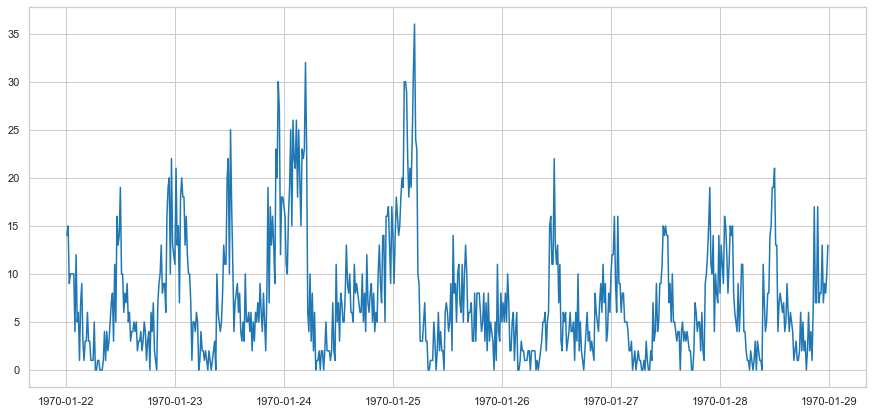

In [21]:
one_week = df2g[(df2g['login_time'] > "1970-01-22") & (df2g['login_time'] < "1970-01-29")]

y = one_week['count']
x = one_week['login_time']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
plt.show()

#### Observations:
- I selected a few random weeks to see if there was consistency week-to-week.  There does appear to be similar trends on a week-to-week basis.

## <font color='orange'>Let's look at logins per month</font>

''

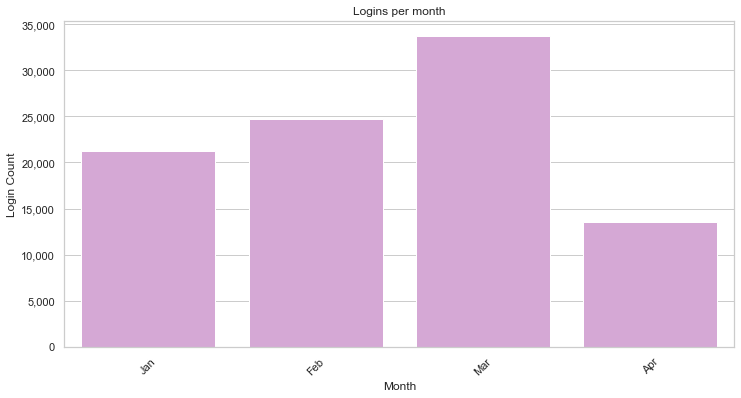

In [22]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr']
#df_day = pd.DataFrame(df2g.groupby('time')['count'].sum().sort_values(ascending=False).reset_index())
df_month = pd.DataFrame(df2g.groupby('month')['count'].sum().reset_index())
#df_day

fig, ax = plt.subplots(figsize = (12 , 6))
#plt.figure(figsize=(12,6))
plt.title("Logins per month")
sns.barplot(x = 'month', y = 'count', data = df_month,
            color = color_choice1, order=month_order
            )

#ax.set_ylabel("Damage (USD Billions)" , size = 12 )
ax.set_xlabel( "Month" , size = 12 )
ax.set_ylabel( "Login Count" , size = 12 )
ax.yaxis.set_major_formatter('{x:,.0f}')
#plt.xticks(rotation=90)
#plt.xticks(np.arange(0, len(df_month)+1, 4))
plt.xticks(rotation=45)
;

#### Observations:
- Usage steadily increased from the beginning of the year and peaked in March, with a precipitous decline in April. It would be itnerested to see if there was a similar quarterly pattern in the data for the duration of the year.

#### Let's look at logins over the course of a month

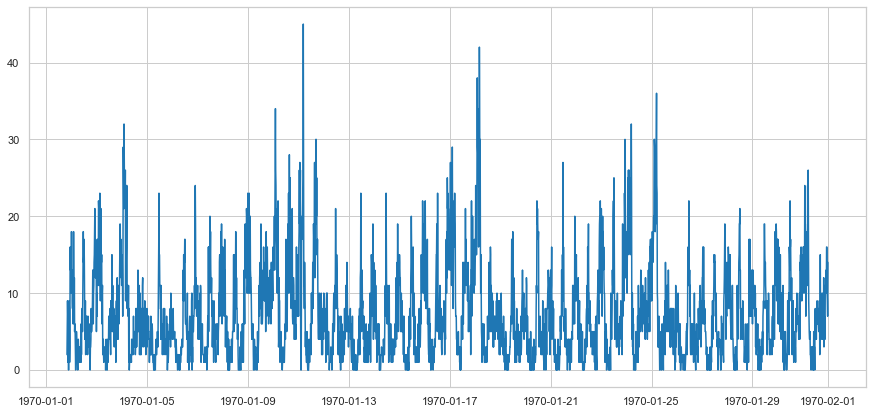

In [23]:
one_month = df2g[df2g['login_time'] < "1970-02-01"]
y = one_month['count']
x = one_month['login_time']

#plt.figure(figsize=(15,7))
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(x,y)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

# Part 2 - Experiment and metrics design

#### Question 1 - primary success metric
- I would choose the average earnings per day per driver as a success metric for this experiment.  This metric would indicate to us whether the changes we have made have improved the financial rewards for the drivers.  Presumably the drivers need to see improved earnings in order to travel the additional distance across the bridge.

#### Question 2 - experiment proposal

a) Experiment implementation
  - A/B test - split population 50/50
  - for the test variant, we will reimburse drivers that make the trip across the bridge.
  - control variant, everything would be the same
  - run the experiment for a period of time where we can get a read of statistical significance on the success metric
  - closely monitor other metrics that could indicate the overall quality of the experience - match rates, driver NPS, customer NPS, driver frequency of usage, driver retention


b) Statistical tests
  - Null hypothesis is that there is no change in driver earnings as a result of the change
  - Alternative hypothesis is that there is a change in driver earnings caused by the change
  - Run experiment at a 95% confidence interval


c) Interpretation
  - If we see evidence to reject the null hypothesis that there is a change in driver earnings caused by the experiment, we would recommend to roll out the feature to the entire population.
  - We would also want to monitor the other metrics mentioned above to ensure that there aren't any negative impacts on the driver and rider experiences.


# Part 3 - Predictive modeling

In [24]:
dfx1

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.0,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [25]:
# profile = ProfileReport(dfx1)
# profile

In [26]:
len(dfx1)

50000

In [27]:
#Drop duplicates
dfx1.drop_duplicates(keep='first', inplace=True) # drop ~60,000 rows that don't have unique track_ID


In [28]:
len(dfx1)

49992

In [29]:
dfx1 = dfx1.reset_index(drop=True)

In [30]:
dfx1

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.0,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.1400000000000001,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49987,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49988,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.0,4.0
49989,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49990,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [31]:
dfx1.signup_date.min()

'2014-01-01'

In [32]:
dfx1.signup_date.max()

'2014-01-31'

In [33]:
dfx1.last_trip_date.max()

'2014-07-01'

In [34]:
dfx1.last_trip_date.min()

'2014-01-01'

In [35]:
dfx1.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [36]:
# figure out how to handle nulls

In [37]:
# start with avg_rating_of_driver
dfx1.avg_rating_of_driver.describe()

count             41,873.0
mean    4.6015117139921236
std     0.6173599585421049
min                    1.0
25%                    4.3
50%                    4.9
75%                    5.0
max                    5.0
Name: avg_rating_of_driver, dtype: float64

In [38]:
dfx1.avg_rating_of_driver.median()

4.9

<AxesSubplot:>

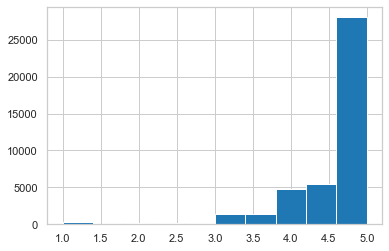

In [39]:
dfx1.avg_rating_of_driver.hist()

In [40]:
# impute with median for avg_rating_of_driver and avg_rating_by_driver
dfx1['avg_rating_of_driver'] = dfx1['avg_rating_of_driver'].fillna(dfx1['avg_rating_of_driver'].median())
dfx1['avg_rating_by_driver'] = dfx1['avg_rating_by_driver'].fillna(dfx1['avg_rating_by_driver'].median())

In [41]:
dfx1.phone.value_counts()

iPhone     34578
Android    15018
Name: phone, dtype: int64

In [42]:
# with 2/3 of phone values as iPhone, simply fill the remaining nulls as iPhone
dfx1['phone'] = dfx1['phone'].fillna('iPhone')

In [43]:
#dfx1[dfx1['avg_dist'] == 8.08]